# Projet de Machine Learning
## Fake News Detection

## Mise en place

Lien avec Gdrive

In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
my_local_drive='/content/gdrive/MyDrive/M1/Projet/donnees'

%cd $my_local_drive
%pwd
%ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/M1/Projet/donnees
HAI817_Projet_test.csv   Models/            Projet_HAI817I.ipynb
HAI817_Projet_train.csv  MyNLPUtilities.py  __pycache__/


Importation des différentes librairies requises

In [2]:
# Librairie a installer
# """ Commenter cette ligne pour installer
!python -m pip install --upgrade pip
!pip install langdetect 
!pip install contractions
!pip install wordcloud==1.8.2.2
!pip install spacy
!pip install nltk

!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!python -m spacy download es_core_news_sm
!pip install spacy-language-detection
!pip install spacy_langdetect==0.1.1
!python -m spacy download fr_core_news_md


!pip install iso639
# """

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=d76f10d1ed2022aa16637a4926b4e094f4129e4bfe421f197a56c47bf8896e74
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1

In [3]:
# Importation des différentes librairies utiles pour le notebook

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# librairies des classifiers utilisés
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from MyNLPUtilities import *

# librairies générales
import pickle 
from scipy.stats import randint
import string
import time
import base64
import sys
import re
import os

import contractions

# librairie BeautifulSoup
from bs4 import BeautifulSoup

# librairie affichage
import wordcloud

## detection de language
import langdetect
from langdetect import detect

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
from nltk import sent_tokenize
from nltk import RegexpParser
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

import spacy
from spacy.tokens import Span
from spacy.lang.fr import French
from spacy_langdetect import LanguageDetector
from spacy.tokens import Doc
from spacy.language import Language
from spacy_language_detection import LanguageDetector

import iso639

import en_core_web_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Récupération du dataset et formatage selon la tâche de classification

In [36]:
df_train = pd.read_csv('HAI817_Projet_train.csv')
df_test = pd.read_csv('HAI817_Projet_test.csv')

# Rennomage des classes pour plus de lisibilité
df_train["our rating"] = df_train["our rating"].replace({"true": "VRAI", 
                                                    "false": "FAUX", 
                                                    "mixture": "MIXTE", 
                                                    "other": "AUTRE"})

df_test["our rating"] = df_test["our rating"].replace({"true": "VRAI", 
                                                    "false": "FAUX", 
                                                    "mixture": "MIXTE", 
                                                    "other": "AUTRE"})

def tacheDeClassification(df, num):
    if num == 1:
        # Sélectionner que les lignes avec "true" ou "false" dans la colonne "our rating"
        df = df[(df['our rating'] == "VRAI") | (df['our rating'] == "FAUX")]
    
    elif num == 2:
        df["our rating"] = df["our rating"].replace({"VRAI": "VRAIouFAUX", 
                                                    "FAUX": "VRAIouFAUX"})

        df = df[(df['our rating'] == "VRAIouFAUX") | (df['our rating'] == "AUTRE")]

    return df.reset_index(drop=True)

tache = 1
# 1 : VRAI vs FAUX
# 2 : VRAIouFAUX vs AUTRE
# 3 : VRAI vs FAUX vs AUTRE vs MIXTURE
dfFakeNews = tacheDeClassification(df_train, tache)
dfFakeNewsTest = tacheDeClassification(df_test, tache)

print(dfFakeNews['our rating'].value_counts())
print(dfFakeNewsTest['our rating'].value_counts())

FAUX    578
VRAI    211
Name: our rating, dtype: int64
FAUX    315
VRAI    210
Name: our rating, dtype: int64


# Pré-traitements

### Visualisation des valeurs manquantes

On supprime ici les lignes avec au moins une colonne vide pour s'assurer qu'il n'y ai pas de données manquantes

<Axes: >

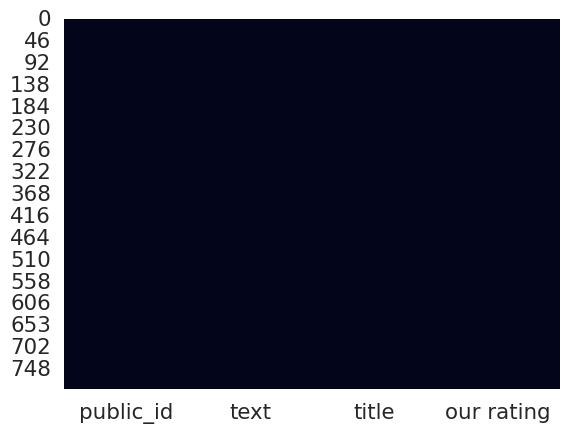

In [39]:
dfFakeNews = dfFakeNews.dropna()
dfFakeNewsTest = dfFakeNewsTest.dropna()

sns.heatmap(dfFakeNews.isnull(), cbar=False)

### Rééquilibrage des classes

Fonction de rééquilibrage des classes

In [40]:
# Ajout de valeurs pour équilibrage
def upSampling(df):
    # Détection du nombre de classes
    classes = df['our rating'].unique()
    num_classes = len(classes)

    if num_classes < 2:
        raise ValueError("Le nombre de classes doit être au moins 2")

    # Détermination de la taille de la classe majoritaire
    counts = df['our rating'].value_counts().sort_values()
    majority_size = counts.iloc[-1]

    # Upsampling des classes minoritaires
    df_upsampled = []
    for c in classes:
        if counts[c] == majority_size:
            df_c = df[df['our rating'] == c]
        else:
            df_c = resample(df[df['our rating'] == c], replace=True, n_samples=majority_size, random_state=42)
        df_upsampled.append(df_c)

    # Concaténation des classes
    df_upsampled = pd.concat(df_upsampled)
    df_upsampled = df_upsampled.reset_index(drop=True)

    return df_upsampled





# Suppression de valeurs pour équilibrage
# Ajout de valeurs pour équilibrage
def downSampling(df):
    # Détection du nombre de classes
    classes = df['our rating'].unique()
    num_classes = len(classes)

    if num_classes < 2:
        raise ValueError("Le nombre de classes doit être au moins 2")

    # Détermination de la taille de la classe minoritaire
    counts = df['our rating'].value_counts().sort_values()
    minority_size = counts.iloc[0]

    # Downsampling des classes majoritaires
    df_downsampled = []
    for c in classes:
        if counts[c] == minority_size:
            df_c = df[df['our rating'] == c]
        else:
            df_c = resample(df[df['our rating'] == c], replace=False, n_samples=minority_size, random_state=42)
        df_downsampled.append(df_c)

    # Concaténation des classes
    df_downsampled = pd.concat(df_downsampled)
    df_downsampled = df_downsampled.reset_index(drop=True)

    return df_downsampled


Rééquilibrage des classes

In [41]:
# Copie du dataFrame
dfPret = dfFakeNews.copy()

print ("Nombre d'occurrences par classe :")
print(dfPret['our rating'].value_counts())
print ("Shape: " + str(dfPret.shape))

# Application du downSampling sur le dataFrame
dfPret = downSampling(dfPret)
# dfPret = upSampling(dfPret)

print ("Après downsampling :")
print(dfPret['our rating'].value_counts())

Nombre d'occurrences par classe :
FAUX    571
VRAI    206
Name: our rating, dtype: int64
Shape: (777, 4)
Après downsampling :
FAUX    206
VRAI    206
Name: our rating, dtype: int64


### Automatisation des pré-traitements

Définition des fonctions

In [8]:
nlp = spacy.load("en_core_web_sm")

# Chargement de la liste de stopwords en anglais
the_stopwords = set(stopwords.words("english"))

# 0. Supprimer les textes qui se sont pas en anglais 
# (à appliquer seulement quand on concatène les titres et les textes ensembles)
def supp_not_english_words(textes):
    tab_langue_textes = []
    # Parcours des textes dans le tableau donnée
    for txt in textes:
        tab_langue_textes.append(langdetect.detect(txt)) # detection de la langue
    # Parcours des langues
    for i in range(len(tab_langue_textes)):
        if tab_langue_textes[i] != 'en': # si la langue n'est pas anglaise
            textes.pop(i) # on supprime le texte dans le tableau d'origine
    return textes


# 1. Generation de wordclouds pour affichage
def generate_wordcloud(texts):
    for text in texts:
        # Detection de la langue
        lang = detect(text)

        # Affichage des word clouds
        wc = wordcloud.WordCloud(
            background_color="black", max_words=100, max_font_size=35
        )
        wc = wc.generate(str(text))
        fig = plt.figure(num=1)
        # Affichage du graphique
        plt.axis("off")
        plt.imshow(wc, cmap=None)
        plt.title(f"Langue: {lang}")
        plt.show()


# 2. Mettre sous forme de token
def tokenize_titles(texts):
    word_tokens_list_texts = []
    # Parcours des textes
    for txt in texts:
        # tokenisation de chaque texte
        word_tokens = word_tokenize(txt)
        word_tokens_list_texts.append(word_tokens)  # ajout à la liste des tokens
    return word_tokens_list_texts


# 3. Donner la categorie des mots
def get_pos_tags(word_tokens_list):
    cate_word_tokens = []
    # Parcours du tableau de token
    for sentence in word_tokens_list:
        sentence_str = " ".join(sentence) # formation de la phrase courante
        doc = nlp(sentence_str) # 
        pos_tags = [
            (token.text, token.pos_) # mot + categorie
            for token in doc
        ] # formation du tableau de chaque mot avec sa catégorie
        cate_word_tokens.append(pos_tags) # ajout dans le tableau de tous les textes
    return cate_word_tokens


# 4. Filtrer les mots en focntion de leurs types selective_pos
def filter_by_pos(text, selective_pos):
    """
    - text (list): une liste de phrases où chaque phrase est une liste de mots.
    - selective_pos (list): une liste de catégories grammaticales à conserver.
            Exemple : ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV', 'PRON']
    """
    filter_cate_word_text = []
    for phrase in text:
        tab_courant = []
        for word in phrase:
            if word[1] in selective_pos:
                tab_courant.append(word)
        filter_cate_word_text.append(tab_courant)
    return filter_cate_word_text


# 5. Suppression des majuscule sur les mots qui ne sont pas des noms propres sauf si on veut tout en minuscule (is_all_min)
def lowercase_filter(filter_cate_word_text, lower, is_all_min):
    min_filter_cate_text = []
    for phrase in filter_cate_word_text:
        mots_minuscules = []
        for word in phrase:
            if lower and (is_all_min or word[1] != "PROPN"):
                mots_minuscules.append(word[0].lower())  # transformer
            else: 
                mots_minuscules.append(word[0])
        min_filter_cate_text.append(mots_minuscules)
    return min_filter_cate_text



# 6. Supprimer les stop words
def remove_stopwords(text):
    # Tokenisation des phrases
    word_tokens_list = []
    for sentence in text:
        word_tokens_list.append(word_tokenize(" ".join(sentence)))
    # Suppression des stopwords et join des tokens
    final_list_sentence = []
    for word_tokens in word_tokens_list:
        tokens = [word for word in word_tokens if word not in the_stopwords]
        # sentence = " ".join(tokens)
        final_list_sentence.append(tokens)
    return final_list_sentence


# 7. Lemmatisation des mots
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmas_final_word_text = []
    for phrase in text:
        doc_lemme = nlp(" ".join(phrase))
        lemmas_courant = []
        for token in doc_lemme:
            if token.text.endswith("-"):
                continue  # enleve les mots composé avec un tiret
            lemmas_courant.append(lemmatizer.lemmatize(token.text))  # ajout a la liste en lematisant le mot
        lemmas_final_word_text.append(lemmas_courant)  # ajout a la grande liste
    return lemmas_final_word_text
    

## Tests
# tok = tokenize_titles(dfPret["title"])
# a = get_pos_tags(tok[:2])
# b = filter_by_pos(a, ['PROPN', 'VERB'])
# c = lowercase_filter(b, False)
# d = remove_stopwords(c)
# e = lemmatize_text(d)
# print(e)

#### Fonction d'automatisation des pré-traitements

In [9]:
def preTraitement(
    texte,
    selective_pos=['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV', 'PRON'], # catégories grammaticales
    filter_category=False,       # filtre les categories de mots qu'on veut
    supp_all_maj=False,          # supprimer toutes les majuscules des textes
    supp_maj=False,              # supprimer les majuscules sur tous les mots sauf les noms propres
    supp_stopwords=False,        # supprimer les stopwords
    lemmatisation=False          # mettre les mots sous leur forme de base
    ):
    """
    Entrée : liste de liste de mots
    Sortie : liste de liste de mots
    """

    # generate_wordcloud(texte)
    tab_texte = tokenize_titles(texte)      # met sous forme de token (tableau de mots)

    if filter_category:
        tab_texte = get_pos_tags(tab_texte) # donne la categorie des mots (LONG)
        tab_texte = filter_by_pos(tab_texte, selective_pos) # ne garde que les selective_pos
        # suppression des MaJ ici car besoin des catégories des mots
        tab_texte = lowercase_filter(tab_texte, supp_maj, supp_all_maj)  # Mise en minuscule

    if supp_stopwords:
        tab_texte = remove_stopwords(tab_texte)  # supprime les stop-words

    if lemmatisation:
        tab_texte = lemmatize_text(tab_texte)   # met sous forme de lemme

    return [" ".join(txt) for txt in tab_texte]

# Traitement

### Transformation du jeu de données

Concaténer les titres aux textes pour pouvoir appliquer sur les deux 

# Classification

Pré-traitement des variables

In [10]:
Xtitle = preTraitement(dfPret["title"], 
                        selective_pos=['NOUN', 'VERB', 'ADJ'],
                        filter_category=False,
                        supp_maj=True,
                        supp_all_maj=True,
                        supp_stopwords=True,
                        lemmatisation=True)

Xtext = preTraitement(dfPret["text"], 
                        selective_pos=['NOUN', 'VERB', 'ADJ'],
                        filter_category=False,
                        supp_maj=True,
                        supp_all_maj=True,
                        supp_stopwords=True,
                        lemmatisation=True)

Concaténation du texte à traiter

In [11]:
X_title_pret = []
X_text_pret = []
X_full_pret = []
for titre, texte in zip(Xtitle, Xtext):
    X_title_pret.append(titre)
    X_text_pret.append(texte)
    X_full_pret.append(titre + " " + texte)

# Variable de prédiction
y_pret = dfPret["our rating"]

### Création du jeu d'apprentissage

Traitement des données avec TF_IDF

In [12]:
def transformationTFIDF(X_pret, y_entree):
    # Transformation du texte en données utilisables par les classifieurs
    tf = TfidfVectorizer(max_features=None, # Mettre un cap sur la taille du tableau
                        max_df=0.8)         # limiter aux mots apparaissant dans moins de 80% des docs
    X_transformed = tf.fit_transform(X_pret).toarray()

    # Séparation du jeu de données
    trainsize = 0.8
    testsize = 1 - trainsize
    seed = 30

    X_train, X_test, y_train, y_test = train_test_split(X_transformed, 
                                                        y_entree, 
                                                        train_size=trainsize, 
                                                        random_state=seed, 
                                                        test_size=testsize)

    return X_transformed, X_train, X_test, y_train, y_test

### Comparaison des classifieurs

In [13]:
models = []
models.append(('MultinomialNB',MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('SVM', SVC()))
seed = 7

def compareClassifiers(X_entree, y_entree):

    print("\n═══════════════════════════════════")
    X_transformed, X_train, X_test, y_train, y_test = transformationTFIDF(X_entree, y_entree)

    for name, model in models:
        print("╔════════"+len(name)*"═"+"════════╗")
        print("║        "+name+"        ║")
        print("╚════════"+len(name)*"═"+"════════╝")
        start_time = time.time()
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        classes = np.unique(y_test)
        print(f"Accuracy : {round(accuracy_score(y_test,y_pred),3)}, temps : {round(time.time() - start_time,2)}s")
        # cnf_matrix = confusion_matrix(y_test,y_pred)
        # plot_confusion_matrix(cnf_matrix, classes)

    return X_transformed, X_train, X_test, y_train, y_test

In [14]:
X_full_transformed, X_train, X_test, y_train, y_test  = compareClassifiers(X_full_pret, y_pret)


═══════════════════════════════════
╔═════════════════════════════╗
║        MultinomialNB        ║
╚═════════════════════════════╝
Accuracy : 0.675, temps : 0.09s
╔══════════════════╗
║        LR        ║
╚══════════════════╝
Accuracy : 0.747, temps : 0.56s
╔═══════════════════╗
║        KNN        ║
╚═══════════════════╝
Accuracy : 0.578, temps : 0.41s
╔════════════════════╗
║        CART        ║
╚════════════════════╝
Accuracy : 0.554, temps : 1.45s
╔════════════════════════════╗
║        RandomForest        ║
╚════════════════════════════╝
Accuracy : 0.675, temps : 1.49s
╔═══════════════════╗
║        SVM        ║
╚═══════════════════╝
Accuracy : 0.747, temps : 4.38s


### Comparaison des classifieurs avec des K-fold

In [15]:
def compare_models(models, X_transformed, y, score):
    seed = 7

    allresults = []
    results = []
    names = []

    for name, model in models:
        print("════════════════════════════════")
        print(f"Evaluation de {name}")
        start_time = time.time()

        # cross validation en 10 fois
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

        # application de la classification
        cv_results = cross_val_score(model, X_transformed, y, cv=kfold, scoring=score)
        y_pred = cross_val_predict(model, X_transformed, y, cv=kfold)
        print(classification_report(y, y_pred))

        thetime = time.time() - start_time
        result = Result(name, cv_results.mean(), cv_results.std(), thetime)
        allresults.append(result)

        # pour affichage
        results.append(cv_results)
        names.append(name)

    allresults = sorted(allresults, key=lambda result: result.scoremean, reverse=True)

    # affichage résultats par score décroissant
    print("\n Résultats :")
    for result in allresults:
        print(f"{result.name} ({round(result.timespent,1)}s) :")
        print(f" - {score} : {round(result.scoremean,3)}")
        print(f" - equart-type : {round(result.stdresult,3)}")

    # affichage graphique
    fig = plt.figure()
    fig.suptitle(f"Comparaison des classifieurs en fonction de {score}")
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    ax.tick_params(axis='x', labelsize=10)

    return allresults[0].name

Comparaison des classifieurs avec un k-fold

════════════════════════════════
Evaluation de MultinomialNB
              precision    recall  f1-score   support

        FAUX       0.83      0.60      0.69       206
        VRAI       0.69      0.88      0.77       206

    accuracy                           0.74       412
   macro avg       0.76      0.74      0.73       412
weighted avg       0.76      0.74      0.73       412

════════════════════════════════
Evaluation de LR
              precision    recall  f1-score   support

        FAUX       0.71      0.80      0.75       206
        VRAI       0.77      0.68      0.72       206

    accuracy                           0.74       412
   macro avg       0.74      0.74      0.74       412
weighted avg       0.74      0.74      0.74       412

════════════════════════════════
Evaluation de KNN
              precision    recall  f1-score   support

        FAUX       0.69      0.57      0.62       206
        VRAI       0.63      0.74      0.68       206

    accuracy        

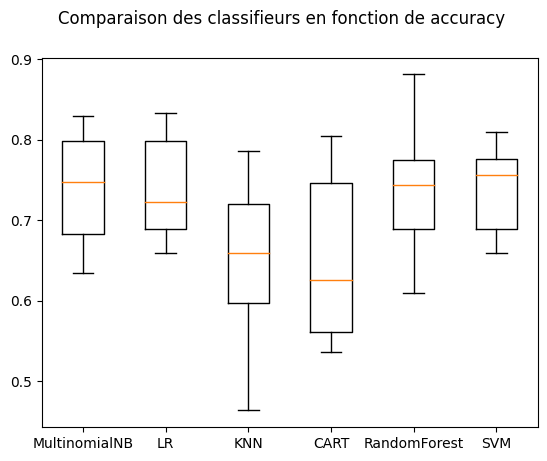

In [16]:
best_accuracy = compare_models(models, X_full_transformed, y_pret, "accuracy")

## Etude du meilleur classifieur

### Définition des paramètres

In [17]:
params = {
 'GaussianNB' :
    [{'var_smoothing': np.logspace(0,-9, num=100)}],

 'RandomForest':[{'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}],

 'LR' : [{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }],

  'CART' : [{'max_depth': [2, 3, 5, 10, 21],
    'min_samples_leaf': [5, 10,16 ,20, 50, 100],
    'criterion': ["gini", "entropy"]}],

  'SVM' : [{
      'C': [0.1,1, 10, 100], 
      'gamma': [1,0.1,0.01,0.001],
      'kernel': ['rbf', 'poly', 'sigmoid']}
           ],

  'KNN' : [{ 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}],

  'MultinomialNB' : [{
    'alpha': np.linspace(0.5, 1.5, 6),
    'fit_prior': [True, False]}]
}

params_lite = {
    'GaussianNB' :
        [{'var_smoothing': np.logspace(0,-9, num=100)}],

    'RandomForest':[{'n_estimators': [4, 6, 9],
           'max_features': ['log2', 'sqrt','auto'],
           'criterion': ['entropy', 'gini'],
           'max_depth': [10, 20],
           'min_samples_split': [2, 3, 5],
           'min_samples_leaf': [1,5,8]
           }],

    'LR' : [{'C' : [0.001,0.01,0.1,1,10,100]}],

    'CART' : [{'max_depth': [1,2,3,4,5,6,7,8,9,10],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}],

    'SVM' : [{'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma' : [0.001, 0.01, 0.1, 1],
              'kernel': ['linear','rbf']}],

    'KNN' : [{ 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}],

    'MultinomialNB' : [{
        'alpha': np.linspace(0.5, 1.5, 6),
        'fit_prior': [True, False]}]
}

Récupération des paramètres du meilleur classifieur

In [18]:
print(f"Meilleur classifieur pour l'accuracy : {best_accuracy}")
    
for name, model in models:
    if best_accuracy == name:
        best_model_name = name
        best_model = model
        best_params_lite = params_lite[name]
        best_params = params[name]  # Long 💀💀💀
        break

Meilleur classifieur pour l'accuracy : SVM


## Variation des hyperparamètres du meilleur classifieur

Fonction de test des hyperparamètres

In [19]:
def testDesHyperParams(model, params, score):
    gd_sr = GridSearchCV(estimator=model,
                        param_grid=params,
                        scoring=score,
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True)

    gd_sr.fit(X_train, y_train)

    return gd_sr

Tests des hyperparamètres sur les différents scores

In [21]:
score = "accuracy"

gridSearch = testDesHyperParams(best_model, best_params_lite, score)
best_estimator = gridSearch.best_estimator_

print(f"meilleur score pour {score} : {round(gridSearch.best_score_, 3)}")
print(f"meilleurs paramètres : {gridSearch.best_params_}")
print(f"meilleur estimateur : {best_estimator}")

meilleur score pour accuracy : 0.784
meilleurs paramètres : {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
meilleur estimateur : SVC(C=1, gamma=0.001, kernel='linear')


## Création du pipeline

Fonction pour la création du pipeline

In [42]:
def grosPipeline(toTrain, toPredict, estimator):

    # Application du downSampling sur les dataFrames
    toTrain = downSampling(toTrain)
    toPredict = downSampling(toPredict)

    XtitleTrain = toTrain["title"]
    XtextTrain = toTrain["text"]
    XallTrain = []
    for titre, texte in zip(XtitleTrain, XtextTrain):
        XallTrain.append(titre + " " + texte)

    XtitleTest = toPredict["title"]
    XtextTest = toPredict["text"]
    XallTest = []
    for titre, texte in zip(XtitleTest, XtextTest):
        XallTest.append(titre + " " + texte)

    X_train = preTraitement(XallTrain, 
                                selective_pos=['NOUN', 'VERB', 'ADJ'],
                                filter_category=False,
                                supp_maj=True,
                                supp_all_maj=True,
                                supp_stopwords=True,
                                lemmatisation=True)

    X_test = preTraitement(XallTest, 
                            selective_pos=['NOUN', 'VERB', 'ADJ'],
                            filter_category=False,
                            supp_maj=True,
                            supp_all_maj=True,
                            supp_stopwords=True,
                            lemmatisation=True)    
    

    y_train = toTrain["our rating"]
    y_test = toPredict["our rating"]
    
    # X_train, X_test, y_train, y_test = train_test_split(X_train, 
    #                                                   y_train, 
    #                                                   train_size=0.8, 
    #                                                   random_state=40, 
    #                                                   test_size=0.2)
    

    tf = TfidfVectorizer()
    X_train_transformed = tf.fit_transform(X_train).toarray()
    X_test_transformed = tf.transform(X_test).toarray()

    clf = RandomForestClassifier()

    # Entrainer le classifieur sur le jeu de données d'entraînement
    clf.fit(X_train_transformed, y_train)

    # Faire des prédictions sur le jeu de données de test
    y_pred = clf.predict(X_test_transformed)
                                                  
    # Calculer les métriques d'évaluation
    class_names = toTrain["our rating"].unique().tolist()
    p, r, f, s = precision_recall_fscore_support(y_test, y_pred, labels=class_names)

    print(f"Performances du pipe : accuracy = {round(accuracy_score(y_test, y_pred),3)}")
    # Affichage les résultats
    print("════════════════════════════════")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("════════════════════════════════")
    print("Precision, recall, f1-score et support par classe :")
    for i, (lbl, a, b, c, d) in enumerate(zip(class_names, p, r, f, s)):
      print(f"Classe {lbl} : {round(a,2)}, {round(b,2)}, {round(c,2)}, {d}")
    print("════════════════════════════════")
    print("Matrice de confusion : ")
    plot_confusion_matrix(confusion_matrix(y_test,y_pred), np.unique(y_test))

## Utilisation du pipeline sur le jeu de test

Performances du pipe : accuracy = 0.683
════════════════════════════════
Classification report:
              precision    recall  f1-score   support

        FAUX       0.64      0.84      0.73       210
        VRAI       0.77      0.52      0.62       210

    accuracy                           0.68       420
   macro avg       0.70      0.68      0.68       420
weighted avg       0.70      0.68      0.68       420

════════════════════════════════
Precision, recall, f1-score et support par classe :
Classe FAUX : 0.64, 0.84, 0.73, 210
Classe VRAI : 0.77, 0.52, 0.62, 210
════════════════════════════════
Matrice de confusion : 


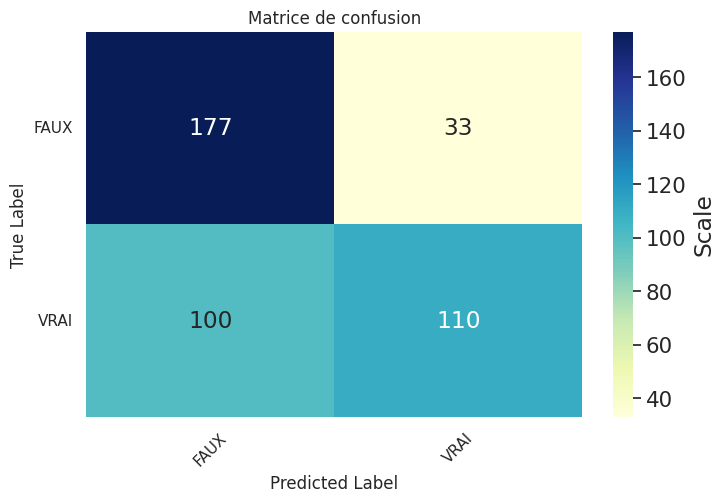

In [43]:
dfTrain = dfFakeNews.copy()
dfTest = dfFakeNewsTest.copy()

grosPipeline(dfTrain, dfTest, best_estimator)

## Mise en production du modèle

## Fonction pour la mise en production du modèle

In [44]:
def miseEnProduction(toPredict, filename, estimator):

    # Application du downSampling sur le dataFrame
    toPredict = downSampling(toPredict)

    Xtitle = toPredict["title"]
    Xtext = toPredict["text"]
    Xall = []
    for titre, texte in zip(Xtitle, Xtext):
        Xall.append(titre + " " + texte)

    X_pret = preTraitement(Xall, 
                            selective_pos=['NOUN', 'VERB', 'ADJ'],
                            filter_category=False,
                            supp_maj=True,
                            supp_all_maj=True,
                            supp_stopwords=True,
                            lemmatisation=True)
    

    y = toPredict["our rating"]
    
    tf = TfidfVectorizer()
    X_transformed = tf.fit_transform(X_pret).toarray()

    scaler = StandardScaler()
    scaler.fit(X_transformed)
    
    model = estimator
    model.fit(X_transformed, y)

    pickle.dump(model, open(f"{filename}-model.pkl", 'wb'))
    pickle.dump(tf, open(f"{filename}-vectorizer.pkl", 'wb'))
    pickle.dump(scaler, open(f"{filename}-scaler.pkl", 'wb'))

    print(f"Modèle sauvegardé dans : {filename}")

Fonction de prédiction utilisant le modèle enregistré

In [45]:
def predict_fake_news(article, filename):
    
    model = pickle.load(open(f"{filename}-model.pkl", 'rb'))
    vectorizer = pickle.load(open(f"{filename}-vectorizer.pkl", 'rb'))
    scaler = pickle.load(open(f"{filename}-scaler.pkl", 'rb'))

    X_entree = preTraitement(article,
                            selective_pos=['NOUN', 'VERB', 'ADJ'],
                            filter_category=False,
                            supp_maj=True,
                            supp_all_maj=True,
                            supp_stopwords=True,
                            lemmatisation=True)
    
    # tf = TfidfVectorizer()        
    X_transformed = vectorizer.transform(X_entree).toarray()

    # Appliquer le scaler sur le vecteur de caractéristiques
    X_test_scaled = scaler.transform(X_transformed)

    # Prédire la classe du texte en entrée
    prediction = model.predict(X_test_scaled)
    
    # Afficher la prédiction
    for i in range(len(prediction)):
      print(f"L'article {i+1} est : {prediction[i]}")

Mise en production du modèle avec le jeu de données au complet

In [46]:
filename = "Models/FakeNewsTrue-False"
if not os.path.exists("Models"):
    os.makedirs("Models")

dfProd = dfFakeNews.copy()

miseEnProduction(dfProd, filename, best_estimator)

Modèle sauvegardé dans : Models/FakeNewsTrue-False


## Prédiction d'articles avec le modèle

Prédiction d'un vrai article du New York Times

In [47]:
articles_a_tester = []

# Articles vrais (New York Time)
title1 = u"""Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley"""
text1 = u"""After years of scorning the political process, Silicon Valley has leapt into the fray. The prospect of a President Donald J. Trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists. A distinguished venture capital firm emblazoned on its corporate home page an earthy   epithet. One prominent tech chieftain says the consequences of Mr. Trump’s election would “range between disastrous and terrible. ” Another compares him to a dictator. And nearly 150 tech leaders signed an open letter decrying Mr. Trump and his campaign of “anger” and “bigotry. ” Not quite all the action is  . Peter Thiel, a founder of PayPal and Palantir who was the first outside investor in Facebook, spoke at the Republican convention in July. The New York Times reported on Saturday that Mr. Thiel is giving $1. 25 million to support Mr. Trump’s candidacy even as other supporters flee. (He also recently gave $1 million to a “super PAC” that supports Senator Rob Portman, the Republican freshman running for   in Ohio.) Getting involved in politics used to be seen as clashing with Silicon Valley’s value system: You transform the world by making problems obsolete, not solving them through Washington. Nor did entrepreneurs want to alienate whatever segment of customers did not agree with them politically. Such reticence is no longer in style here. “We’re a bunch of nerds not used to having a lot of limelight,” said Dave McClure, an investor who runs a tech incubator called 500 Startups. “But to quote   ‘With great power comes great responsibility. ’” Mr. McClure grew worried after the Republican and Democratic conventions as Mr. Trump began to catch up to Hillary Clinton in the polls. He wanted Silicon Valley to do more, and so late last month he announced Nerdz4Hillary, an informal   effort. An initial group of donors pledged $50, 000 the goal was to ask the “nerdz” for small donations to match that sum. They have not come through yet. “We’re kind of optimistic we’ll get the other $50, 000 in a few weeks,” Mr. McClure said. That relatively slow pace reflects Silicon Valley’s shifting position: Even as it becomes increasingly free with its opinions, it has been less free with its checkbook. The most recent data, from late August, shows Mrs. Clinton taking in $7. 7 million from the tech community, according to Crowdpac, a   that tracks donations. By that point in 2012, Crowdpac says, President Obama had raised $21 million from entrepreneurs and venture capitalists. Reid Hoffman, the billionaire   of the business networking site LinkedIn, offers a snapshot of Silicon Valley’s evolving approach to politics. Mr. Hoffman was a top Obama donor, giving $1 million to the Priorities USA political action committee, something several of his peers did as well. Last month, Mr. Hoffman garnered worldwide publicity for saying he would donate up to $5 million to veterans’ groups if Mr. Trump released his taxes, a remote possibility that never came to pass. He has castigated Mr. Trump in interviews, saying he was speaking for those who were afraid. Mr. Hoffman’s outright donations, however, have been smaller this election cycle. In May, he gave $400, 000 to the Hillary Victory Fund. Asked if there was more recent giving that had not shown up in federal election records, Mr. Hoffman cryptically responded in an email, “Looking at some PACs, etc. ” He declined several opportunities to elaborate. Even as Priorities USA has raised $133 million this election cycle, far exceeding its total in 2012, its tech contributions have dwindled. The only familiar tech name this time around is John Doerr of the venture capital firm Kleiner Perkins Caufield  Byers, who gave $500, 000. The AOL   Steve Case said his September endorsement of Mrs. Clinton, via an   in The Washington Post, was the first time he ever publicly declared for a candidate. “I always focused on policy and avoided politics,” he said. “But if Trump were elected president, I would be disappointed in myself for not acting. ” When he wrote the   he was uncertain about donating money to Mrs. Clinton, saying only that it was “probable. ” A spokeswoman said Sunday that Mr. Case gave $25, 000 to the Hillary Victory Fund. Mason Harrison, Crowdpac’s head of communications, offered a possible reason for Mrs. Clinton’s    support. “Donors give to support candidates they love, not to defeat candidates they fear,” he said. A few billionaires are acting instead of talking. Dustin Moskovitz, a founder of Facebook, said he was giving $20 million to various Democratic election efforts  —   the first time he and his wife, Cari Tuna, have endorsed a candidate. He declined to be interviewed. Part of the problem for Mrs. Clinton is that, however preferable she may be to Mr. Trump in the tech community, she pales in comparison to President Obama. After some initial misgivings, Silicon Valley found its champion in him. There has been a revolving door between tech and the Obama administration, just as previous Democratic administrations had a revolving door with Wall Street. In June, President Obama seemed to suggest that he might become a venture capitalist after his term ends. Mrs. Clinton is not as enthusiastic toward Silicon Valley and its disruptive ways. In a speech in the summer of 2015, she noted that   in the “  or   gig economy”  —   Uber, Airbnb and their ilk  —   were “unleashing innovation” but also “raising hard questions about workplace protection and what a good job will look like in the future. ” The Clinton campaign declined to comment. The Trump campaign did not respond to a query. Even as Silicon Valley works against Mr. Trump, there is quiet acknowledgment that his campaign has bared some important issues. In an endorsement this month of Mrs. Clinton, the venture capital firm Union Square Ventures pointed out that “the benefits of technology and globalization have not been evenly distributed,” and that this needed to change. If Silicon Valley’s political involvement outlasts this unusual election, the tech community may start contributing more to the process than commentary and cash. “Not only are tech people going to be wielding influence, but they’re going to be the candidate,” Mr. McClure said. “Reid Hoffman, Sheryl Sandberg”  —   the chief operating officer of Facebook  —   “and a bunch of other folks here have political aspirations. ” Others may be inspired to enter politics through other doors. Palmer Luckey is the    founder of the Oculus virtual reality company, which he sold to Facebook for $2 billion. Mr. Luckey donated $10, 000 to a group dedicated to spreading    messages about Mrs. Clinton both online and off. The group’s first billboard, said to be outside Pittsburgh, labeled her “Too Big to Jail. ” Mr. Luckey told The Daily Beast that his thinking “went along the lines of, ‘Hey, I have a bunch of money. I would love to see more of this stuff. ’He added, I thought it sounded like a real jolly good time. Many virtual reality developers were less happy, and Mr. Luckey quickly posted his regrets on Facebook. He declined to comment further. If we’re going to be more vocal, we’ll have to live more transparently, said Hunter Walk, a venture capitalist whose campaign to persuade tech companies to give workers Election Day off signed up nearly 300 firms, including Spotify, SurveyMonkey and TaskRabbit. There will be a period of adjustment. But perhaps being vocal is a temporary condition after all. The venture firm CRV was in the spotlight at the end of August with its blunt   message, which included the earthy epithet. A few weeks later, it cleaned up its website. The partners went from employing a publicist to seek out attention to declining interviews. We reached everyone we wanted to reach, and hopefully influenced opinions, said Saar Gur, a CRV venture capitalist. Then the buzz died down and we went back to our day jobs, which are super busy."""
title2 = u"""Many in U.K. Greet King Charles’s Coronation With a ‘Take It or Leave It’ Shrug"""
text2 = u"""When King Charles III is crowned on Saturday, he will undergo a ritual so rare in modern British history that it last occurred 70 years ago, roughly the wait between sightings of Halley’s comet. And yet the coronation has yet to capture the imagination of a Britain preoccupied by other concerns. Images of the new king — in chocolate, in Legos and in wax — are popping up in bakeries, toy stores and at Madame Tussauds wax museum. Ancient relics of coronation, like the Scottish stone of destiny, are being delivered to Westminster Abbey for the ceremony. Charles and his queen consort, Camilla, are rehearsing every step of the service in a specially staged room at Buckingham Palace. But in a recent poll of 3,070 adults in Britain by the market research firm YouGov, 64 percent of respondents said they had little or no interest in the coronation. Only a third said they were strongly or fairly interested in it. Among those aged 18 to 24, the number voicing little or no interest rose to 75 percent. “Love for the royal family has sort of declined,” said Jason Abdalla, 24, an information technology worker outside a pub last Friday in the exclusive Mayfair neighborhood of London. “It feels like appreciating the monarchy is an older, more mature thing. I mean, my parents are into it. They love the royal family. It’s ‘take it or leave it,’ for me.” There are other, less generational explanations for the lack of excitement, like the rainy spring weather, which may loosen its grip in time for the May 6 ceremony, and Britain’s economic doldrums, which have focused public attention on the cost of bread rather than what cynics might label bread-and-circuses. Then, too, there is the contrast between King Charles and his mother, Queen Elizabeth II. Her coronation in 1953 introduced a poised young monarch who was thrust on the throne by the death of her father, King George VI, and became a beloved icon. At 74, Charles is a familiar figure, one whose foibles have been dissected in the news media for decades and who still presides over a dysfunctional family. “He is not a romantic figure like she was,” said Ed Owens, a historian who has written about the interplay between the monarchy and the news media. “He is a complex human personality whose private life we know a great deal more about than we did with the queen in 1953.” Whereas the queen’s coronation symbolized a new start for the country and the royal family, Mr. Owens said, Charles’s coronation comes after a period of family feuds that has left the House of Windsor divided and diminished. “He’s inheriting a crown that has been shaken by events over the last five years, and tarnished by those events as well,” Mr. Owens said."""
title3 = u"""Airman in Leaks Case Worked on a Global Network Essential to Drone Missions"""
text3 = u"""WASHINGTON — On an Air National Guard base in Cape Cod, Mass., more than 1,200 military service members and civilians maintain one of the largest support systems for Pentagon drone missions around the world. One of the workers was Airman First Class Jack Teixeira, the 21-year-old accused of posting top-secret military reports online. Why such a young junior-ranking service member on Cape Cod had access to sensitive intelligence, including battlefield updates on the war in Ukraine, has to do with the vast expansion in military drone operations in the post-9/11 wars that was made possible by better satellite communication networks. It is also the result of a drastic reorganization in the Air National Guard that left small, far-flung air bases in need of new responsibilities. The one on Cape Cod and many others became intelligence outfits. His arrest and subsequent Justice Department disclosures shined a light on a little-known Air Force mission that began in the 1990s and grew rapidly, eventually spreading to the base on Cape Cod. Called the Distributed Common Ground System, it is a vast computer network that handles the immense amounts of data generated by surveillance drones, spy satellites and other sensors — information that intelligence analysts pore through and pass along to troops on the ground. Usually referred to as D.C.G.S., it carries top-secret information, and working on it requires an equivalent security clearance. The system is now a worldwide network, but according to the Air Force, it started small at just three Air Force bases — Langley in Virginia, Beale in California and Osan in South Korea — and expanded in the early 2000s as the U.S. military placed more communication satellites in space and demand for airborne surveillance surged. In 2001, according to Pentagon leadership, the U.S. military had about 200 drones in service. In the years that followed, commanders in Afghanistan and later in Iraq wanted more of them. Many more. The network soon expanded to two more bases: Ramstein, in Germany, in early 2003 and Hickam, in Honolulu, in late 2004, Air Force documents say. According to two retired Air Force intelligence officers with direct experience in the system, a key decision by Congress at that time freed up a large labor pool to serve at new sites. In 2005, the Pentagon’s Base Realignment and Closure commission made recommendations that affected most of the Air National Guard’s aviation units, with 14 of them losing their flying mission, the Government Accountability Office reported. The move left thousands of air guardsmen without jobs, the officers said, speaking on the condition of anonymity because of their continuing work for companies that do business with the federal government. One of those units was the 102nd Fighter Wing at a base called Otis on Cape Cod. Men and women from that Air National Guard wing and other former flying units began training to work on the Distributed Common Ground System, learning to run its computers and analyze intelligence from spy planes and the ever-increasing numbers of drones flying in combat missions overseas, the retired officers said. In a speech to the Air War College in 2008, Robert M. Gates, then the secretary of defense, said the number of unmanned aircraft in service with the U.S. military had increased to more than 5,000. Stations for the network were soon established at Air National Guard bases in Indiana and at Otis, where Jack Teixeira’s stepfather made the transition from the 102nd Fighter Wing to a post at the newly christened 102nd Intelligence Wing. Today, there are 27 D.C.G.S. stations in the United States and two foreign countries, according to Air Force documents. But the original five are the busiest, operating nonstop year-round, the retired officers said. Each of those sites is supported by a corresponding Air National Guard unit. The unit in Germany is currently in great demand because it serves the U.S. European Command, and, by extension, America’s support of Ukraine in its war with Russia. The Ramstein station is backed up by the 102nd Intelligence Wing at Joint Base Cape Cod, the officers said, which is supported by the 102nd Intelligence Support Squadron, where Airman Teixeira is stationed. By 2019, when Airman Teixeira joined the Air National Guard, the U.S. military was operating more than 11,000 drones, according to the Pentagon. In 2021, his top-secret clearance was approved, Justice Department charging documents said, allowing him entry into the facility, which has an operations floor filled with computer terminals and flat-screen televisions showing live video feeds from classified drone missions. Some sites have operations facilities many thousands of square feet in size, the officers said. Cellphones are not allowed inside. Small teams of airmen at the units typically talk to pilots flying high-altitude U-2 spy planes and RQ-4 Global Hawks as well as MQ-9 Reapers and MQ-1 Predators over combat zones. Airmen like Mr. Teixeira typically fix hardware and software problems and conduct routine maintenance for hours at a time in what is essentially an I.T. support shop while others collect intelligence that they can transmit to ground forces around the world, the officers said. According to his messages on Discord, Airman Teixeira alternated between working eight-hour shifts five days a week and 12-hour shifts for three or four days at a time followed by three or four days off. How the intelligence reports were allegedly removed from secure spaces remains unclear. President Biden has instructed officials to get to the root of why Airman Teixeira “had access in the first place,” and Pentagon leaders are reviewing how intelligence is shared and who will have access to certain reports in the future. The Air Force announced on April 18 that it had temporarily shut down the 102nd Intelligence Wing’s missions, which have been transferred to “other organizations” in the service. In the most recent fallout, two of Airman Teixeira’s superiors at the wing have been suspended pending the completion of an internal investigation by the Air Force inspector general, the service said. Their access to classified information has been temporarily blocked, a spokeswoman added."""

# Articles faux (WELFake Dataset)
title4 = u"""Schumer calls on Trump to appoint official to oversee Puerto Rico relief"""
text4 = u"""WASHINGTON (Reuters) - Charles Schumer, the top Democrat in the U.S. Senate, called on President Donald Trump on Sunday to name a single official to oversee and coordinate relief efforts in hurricane-ravaged Puerto Rico. Schumer, along with Representatives Nydia VelÃ zquez and Jose Serrano, said a â€œCEO of response and recoveryâ€ is needed to manage the complex and ongoing federal response in the territory, where millions of Americans remain without power and supplies. In a statement, Schumer said the current federal response to Hurricane Mariaâ€™s impact on the island had been â€œdisorganized, slow-footed and mismanaged.â€ â€œThis person will have the ability to bring all the federal agencies together, cut red tape on the public and private side, help turn the lights back on, get clean water flowing and help bring about recovery for millions of Americans who have gone too long in some of the worst conditions,â€ he said. The White House did not immediately respond to a request for comment. The Democrats contended that naming a lone individual to manage the governmentâ€™s relief efforts was critical, particularly given that the Federal Emergency Management Agency is already stretched thin from dealing with other crises, such as the aftermath of Hurricane Harvey in Texas and the wildfires in California. The severity of the Puerto Rico crisis, where a million people do not have clean water and millions are without power nearly a month after Hurricane Maria made landfall, demand a single person to focus exclusively on relief and recovery, the Democrats said. Forty-nine people have died in Puerto Rico officially, with dozens more missing. The hurricane did extensive damage to the islandâ€™s power grid, destroying homes, roads and other vital infrastructure. Now, the bankrupt territory is struggling to provide basic services like running water, and pay its bills. â€œItâ€™s tragically clear this Administration was caught flat footed when Maria hit Puerto Rico,â€ said VelÃ zquez. â€œAppointing a CEO of Response and Recovery will, at last, put one person with authority in charge to manage the response and ensure we are finally getting the people of Puerto Rico the aid they need.â€ On Thursday, Trump said the federal response has been a â€œ10â€ on a scale of one to 10 at a meeting with Puerto Rico Governor Ricardo Rossello.  The governor has asked the White House and Congress for at least $4.6 billion in block grants and other types of funding. Senator Marco Rubio called on Congress to modify an $18.7 billion aid package for areas damaged by a recent swath of hurricanes to ensure that Puerto Rico can quickly access the funds."""
title5 = u"""No Change Expected for ESPN Political Agenda Despite Huge Subscriber Decline - Breitbart"""
text5 = u"""As more and more sports fans turn off ESPN to protest the networkâ€™s   social and political agenda, parent company Disneyâ€™s decision to extend current CEO Bob Igerâ€™s contract through 2019 means the â€œworldâ€™s leader in sports entertainmentâ€ will continue on its merry way of alienating a large segment of Americans. [Breitbart reported in November that ESPN lost 3. 2 million subscribers in just over a year. Moreover, for the last few years the sports network has lost 300, 000 subscribers a month. In October alone, the beleaguered network lost 621, 000 subscribers.   The decision to keep Iger instead of moving in another direction, such as promoting COO Thomas Staggs to the spot, has a number of substantial business implications for ESPN. Awful Announcing reports: From the outside, at least, it seems like Iger is quite satisfied with ESPNâ€™s leadership and with the networkâ€™s path on most fronts. Specifically, heâ€™s regularly spoken about how important it is for ESPN to be in â€œskinny bundlesâ€ (including streaming options from Sling, DirecTV and more) and about ESPNâ€™s forthcoming    offering. Those views wouldnâ€™t necessarily be shared by a different CEO Staggs, for example, spoke much more about the importance of the traditional   bundle, so a Disney CEO with his views might focus more on that side, or conversely, another Disney CEO might want ESPN to quickly go into    in a larger way (standalone access to all ESPN content, including TV channels) rather than starting with the   light approach Iger seems to be promoting. Putting those circumstances aside, the crux of ESPN continuing on in its political and social agenda derives from the fact that Iger is a strident lifelong Democrat. One so committed, in fact, that the Disney stalwart   a Hillary Clinton fundraiser last summer along with   supporters such as entertainment Mogul Haim Saban, Chernin Group chairman and CEO Peter Chernin, and entertainment and sports executive Casey Wasserman.  To get an idea of Igerâ€™s taste on social issues, one of his proposed â€œentertainmentâ€ ideas is a filmic version of Girls, a popular television show starring Lena Dunham. Somewhat surprisingly, and to the chagrin of many of his supporters and shareholders, Iger is serving on President Donald Trumpâ€™s Strategic and Policy Forum council of CEOs. Iger agrees with Trump on shutting down certain tax loopholes and strongly supports lowering corporate tax rates (no surprise there).  Earlier this month, Iger reportedly defended his participation in Trumpâ€™s mastermind group, asserting, â€œI think there is an opportunity for me to express views that I think   â€¦     are of value to the company and its shareholders. â€ Insisting that he wonâ€™t be   Iger informs that he will be â€œadversarial to the view of the administration,â€ which includes â€œimmigration. â€ Yet, the CEO argues that claims asserting ESPN is politically slanted are â€œjust a complete exaggeration. â€ With that said, it looks like ESPNâ€™s cable subscription downward spiral will persist as long as Iger remains as Disneyâ€™s top executive."""
title6 = u"""U.N. seeks humanitarian pause in Sanaa where streets "battlegrounds"""
text6 = u"""GENEVA (Reuters) - The United Nations called on Monday for a humanitarian pause in the Yemeni capital of Sanaa on Tuesday to allow civilians to leave their homes, aid workers to reach them, and the wounded to get medical care. Jamie McGoldrick, U.N. humanitarian coordinator in Yemen, said in a statement that the streets of Sanaa had become  battlegrounds  and that aid workers  remain in lockdown .  Thus, I call on all parties to the conflict to urgently enable a humanitarian pause on Tuesday 5 December, between 10:00 a.m. and 16:00 p.m. to allow civilians to leave their homes and seek assistance and protection and to facilitate the movement of aid workers to ensure the continuity of life-saving programs,  he said.  McGoldrick warned the warring parties that any deliberate attacks against civilians, and against civilian and medical infrastructure, are  clear violations of international humanitarian law and may constitute war crimes."""

articles_a_tester.append(title1 + text1)
articles_a_tester.append(title2 + text2)
articles_a_tester.append(title3 + text3)
articles_a_tester.append(title4 + text4)
articles_a_tester.append(title5 + text5)
articles_a_tester.append(title6 + text6)

predict_fake_news(articles_a_tester, filename)

L'article 1 est : VRAI
L'article 2 est : VRAI
L'article 3 est : VRAI
L'article 4 est : VRAI
L'article 5 est : FAUX
L'article 6 est : FAUX
